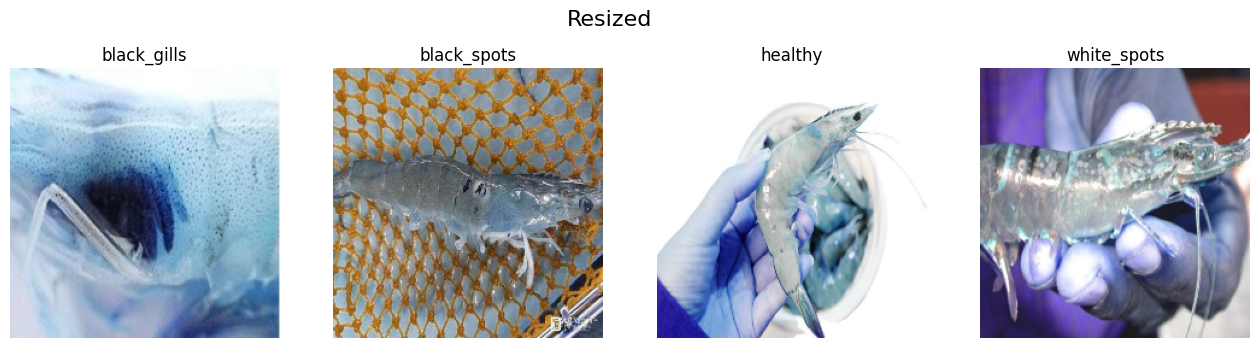

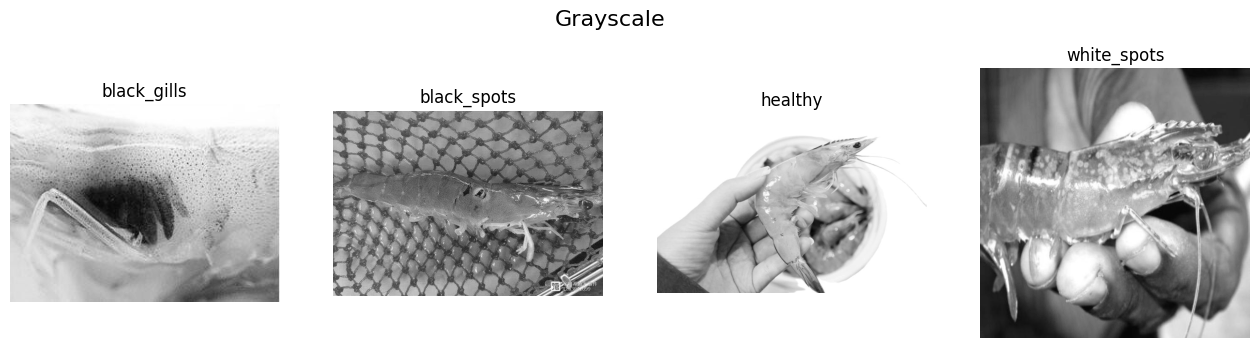

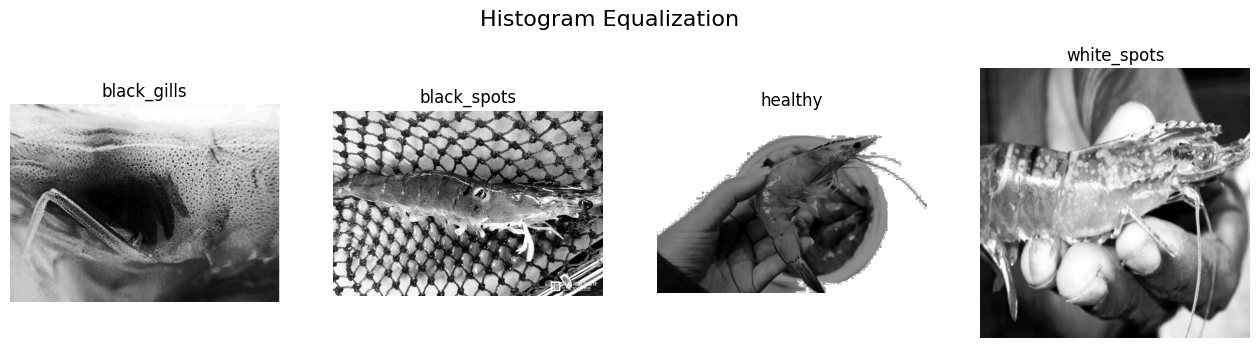

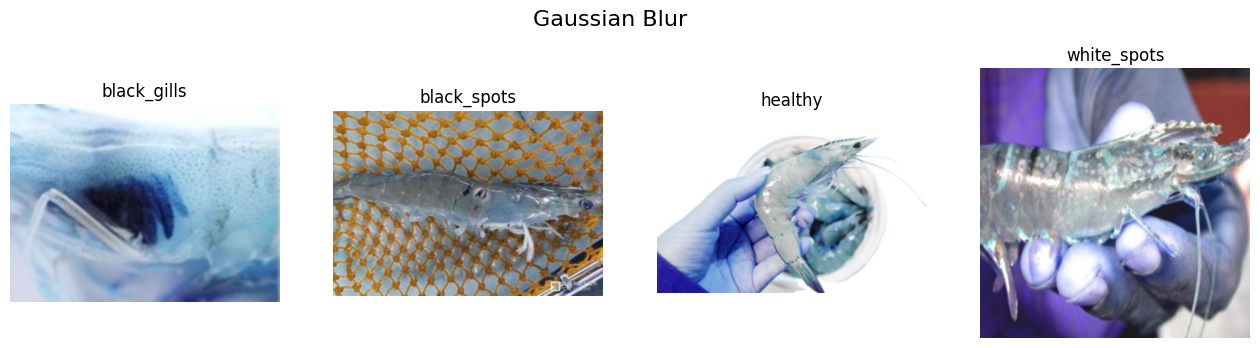

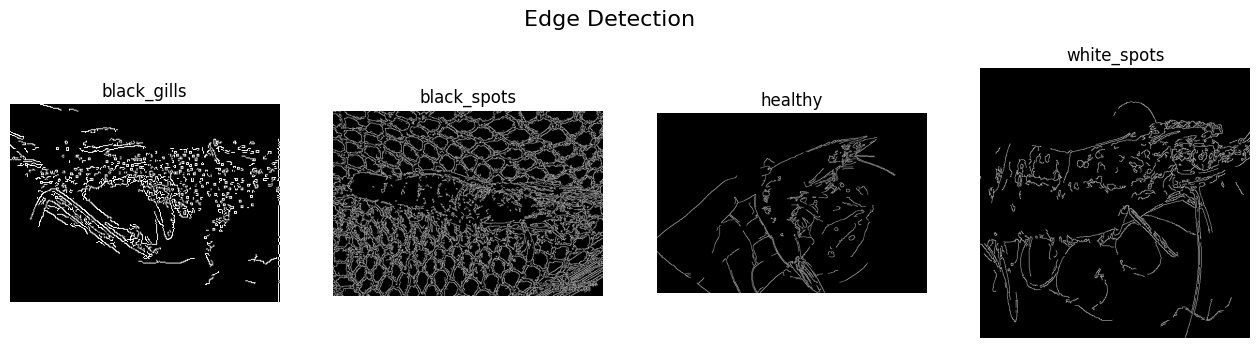

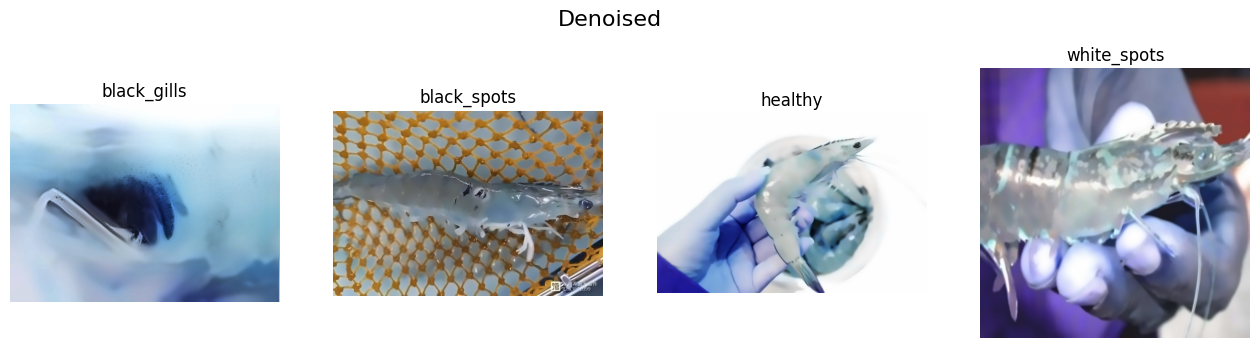

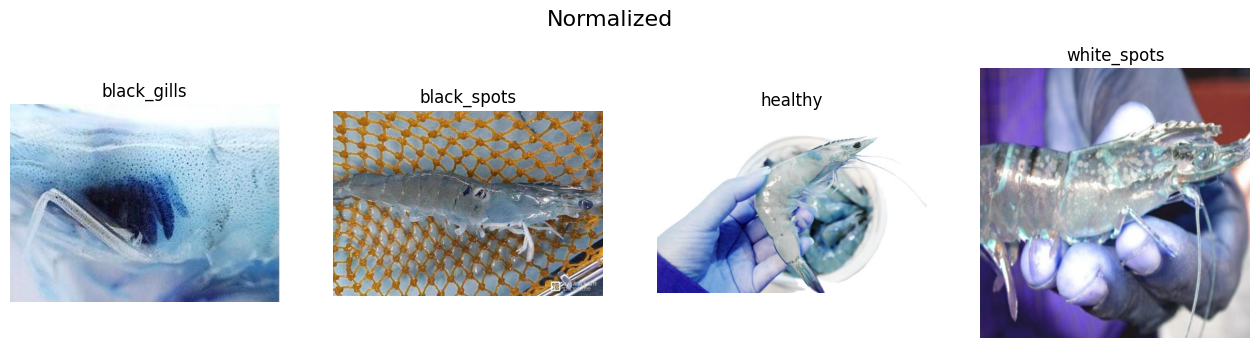

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Defining paths to images
base_dir = "/kaggle/input/deepshrimpdata/shrimpdetectdata"  
labels = ["black_gills", "black_spots", "healthy", "white_spots"]

# Below is the Function to load sample images from each class
def load_sample_images(base_dir, labels):
    sample_images = {}
    for label in labels:
        image_paths = glob(os.path.join(base_dir, label, "*.jpg"))  # Changing the extension if needed
        if image_paths:
            sample_images[label] = cv2.imread(image_paths[0])  # Loading one image per class
    return sample_images

# Load images
sample_images = load_sample_images(base_dir, labels)

# Preprocessing steps
def resize_image(image, size=(224, 224)):     #Resize
    return cv2.resize(image, size)

def convert_to_grayscale(image):                             #grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def histogram_equalization(image):                             #HAV
    return cv2.equalizeHist(image) if len(image.shape) == 2 else cv2.cvtColor(cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)), cv2.COLOR_GRAY2BGR)

def gaussian_blur(image, ksize=(5, 5)):                    #gaussian blur
    return cv2.GaussianBlur(image, ksize, 0)

def edge_detection(image):                                 #edge detection
    return cv2.Canny(image, 100, 200)

def denoise_image(image):                                  #denoise img
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21) if len(image.shape) == 3 else cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

def normalize_image(image):                                 #normalize img                
    return cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Function to visualize preprocessing steps
def visualize_preprocessing(sample_images, steps):
    for step_name, step_func in steps.items():
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        fig.suptitle(step_name, fontsize=16)
        for ax, (label, image) in zip(axes, sample_images.items()):
            processed_image = step_func(image)
            cmap = 'gray' if len(processed_image.shape) == 2 else None
            ax.imshow(processed_image, cmap=cmap)
            ax.set_title(label)
            ax.axis("off")
        plt.show()

# Defining the preprocessing steps
steps = {
    "Resized": resize_image,
    "Grayscale": convert_to_grayscale,
    "Histogram Equalization": histogram_equalization,
    "Gaussian Blur": gaussian_blur,
    "Edge Detection": edge_detection,
    "Denoised": denoise_image,
    "Normalized": normalize_image,
}

# Visualizing preprocessing
visualize_preprocessing(sample_images, steps)

In [2]:
import os
import cv2
import numpy as np
import albumentations as A
from glob import glob

# Paths
actual_dataset_dir = "/kaggle/input/deepshrimpdata/shrimpdetectdata"  # Change to your actual dataset path
preprocessed_dataset_dir = "/kaggle/working/preprocessed_dataset"  # Change to preprocessed dataset path

# Define labels (classes)
labels = ["black_gills", "black_spots", "healthy", "white_spots"]

# Create folders if not exist
os.makedirs(preprocessed_dataset_dir, exist_ok=True)
for label in labels:
    os.makedirs(os.path.join(preprocessed_dataset_dir, label), exist_ok=True)

# Define Data Augmentation using Albumentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),  # Random Horizontal Flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.RandomBrightnessContrast(p=0.5),  # Random Brightness/Contrast
    A.GaussNoise(p=0.3),  # Add Gaussian Noise
])

# Preprocessing Function
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    # 1️⃣ Denoise
    denoised = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)

    # 2️⃣ Histogram Equalization
    hist_eq = cv2.equalizeHist(denoised)

    # 3️⃣ Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    adaptive_hist_eq = clahe.apply(hist_eq)

    # 4️⃣ Normalize (Scale pixel values to [0,1])
    normalized = cv2.normalize(adaptive_hist_eq, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return normalized

# Process & Augment all images
for label in labels:
    input_folder = os.path.join(actual_dataset_dir, label)
    output_folder = os.path.join(preprocessed_dataset_dir, label)

    for image_path in glob(os.path.join(input_folder, "*.jpg")):  # Change extension if needed
        img_name = os.path.basename(image_path)

        # Apply preprocessing
        processed_image = preprocess_image(image_path)

        # Save Preprocessed Image
        cv2.imwrite(os.path.join(output_folder, img_name), processed_image)

        # Convert Image for Augmentation (Albumentations requires HxWxC format)
        processed_image = processed_image[:, :, np.newaxis]  # Add channel dimension
        processed_image = np.repeat(processed_image, 3, axis=2)  # Convert to 3-channel grayscale

        # Generate Augmented Images
        for i in range(3):  # Generate 3 augmented images per original image
            augmented = augmentations(image=processed_image)["image"]
            aug_name = f"{os.path.splitext(img_name)[0]}_aug{i+1}.jpg"
            cv2.imwrite(os.path.join(output_folder, aug_name), cv2.cvtColor(augmented, cv2.COLOR_RGB2GRAY))

# Function to count images
def count_images(dataset_path):
    total_images = 0
    for label in labels:
        image_paths = glob(os.path.join(dataset_path, label, "*.jpg"))  # Change extension if needed
        total_images += len(image_paths)
        print(f"{label}: {len(image_paths)} images")
    return total_images

# Count images
print("\n🔹 *Actual Images in Dataset:*")
actual_images_count = count_images(actual_dataset_dir)

print("\n🔹 *Preprocessed + Augmented Images in Dataset:*")
preprocessed_images_count = count_images(preprocessed_dataset_dir)

print("\n✅ *Total Actual Images:*", actual_images_count)
print("✅ *Total Preprocessed + Augmented Images:*", preprocessed_images_count)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



🔹 *Actual Images in Dataset:*
black_gills: 497 images
black_spots: 483 images
healthy: 492 images
white_spots: 499 images

🔹 *Preprocessed + Augmented Images in Dataset:*
black_gills: 1988 images
black_spots: 1932 images
healthy: 1968 images
white_spots: 1996 images

✅ *Total Actual Images:* 1971
✅ *Total Preprocessed + Augmented Images:* 7884


In [3]:
!pip install timm


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
import os
import shutil
import random

# Paths
input_dir = "/kaggle/input/preprocessedimgs/preprocessed"  # Change this to your actual preprocessed dataset path
output_dir = "/kaggle/working/split_data2"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create train/val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Train-Val Split Ratio
train_ratio = 0.8  # 80% for training, 20% for validation

# Random Seed for Reproducibility
random.seed(42)

# Loop through disease classes
for disease_class in os.listdir(input_dir):
    class_path = os.path.join(input_dir, disease_class)
    if not os.path.isdir(class_path):
        continue  # Skip if not a folder

    # Create class folders in train & val directories
    os.makedirs(os.path.join(train_dir, disease_class), exist_ok=True)
    os.makedirs(os.path.join(val_dir, disease_class), exist_ok=True)

    # Get all images for the class
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)  # Shuffle for randomness

    # Split into train & val
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    val_images = images[train_size:]

    # Move images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, disease_class, img))

    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, disease_class, img))

print("Data Split Complete: Train & Validation sets created!")



Data Split Complete: Train & Validation sets created!


In [6]:
import os
import torch
import timm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to train and validation datasets
train_dir = "/kaggle/working/split_data2/train"
val_dir = "/kaggle/working/split_data2/val"

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize for single channel
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get class names
class_names = train_dataset.classes
print("✅ Classes:", class_names)

# Load ConvNeXt-Tiny Model & Modify for Grayscale Input
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=len(class_names))

# Modify the first convolution layer to accept 1-channel (grayscale)
model.stem[0] = nn.Conv2d(1, 96, kernel_size=4, stride=4, padding=0, bias=False)

# Modify the classification head to match output dimensions
in_features = model.head.fc.in_features  # Get input size of original classifier
model.head.fc = nn.Linear(in_features, len(class_names))  # Modify last layer

model.to(device)

# Define loss function (Label Smoothing for better generalization)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)  # Cosine Annealing

# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_convnext_tiny3.pth")  # Save best model

        scheduler.step()

    print(f"✅ Training complete. Best validation accuracy: {best_val_acc:.2f}%")

def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100 * correct / total

# Start Training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# Load Best Model
model.load_state_dict(torch.load("best_convnext_tiny3.pth"))
model.eval()

# Predict Function
def predict_image(image_path, model):
    image = Image.open(image_path).convert("L")  # Load as grayscale
    image = transform(image).unsqueeze(0).to(device)  # Apply transformation

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    print(f"🔍 Predicted Class: {class_names[predicted.item()]}")

# Example Test Image
test_image_path = "/kaggle/working/split_data2/val/black_spots/Black_spots (482).jpg"  # Change this
predict_image(test_image_path, model)


✅ Classes: ['black_gills', 'black_spots', 'healthy', 'white_spots']


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/30 | Train Loss: 1.4703 | Train Acc: 25.25% | Val Acc: 25.33%
Epoch 2/30 | Train Loss: 1.4082 | Train Acc: 24.50% | Val Acc: 25.33%
Epoch 3/30 | Train Loss: 1.3981 | Train Acc: 26.00% | Val Acc: 24.95%
Epoch 4/30 | Train Loss: 1.3951 | Train Acc: 25.46% | Val Acc: 24.38%
Epoch 5/30 | Train Loss: 1.3908 | Train Acc: 25.80% | Val Acc: 25.33%
Epoch 6/30 | Train Loss: 1.3749 | Train Acc: 29.83% | Val Acc: 24.95%
Epoch 7/30 | Train Loss: 1.3665 | Train Acc: 32.40% | Val Acc: 37.18%
Epoch 8/30 | Train Loss: 1.3523 | Train Acc: 34.31% | Val Acc: 38.25%
Epoch 9/30 | Train Loss: 1.3137 | Train Acc: 38.46% | Val Acc: 40.53%
Epoch 10/30 | Train Loss: 1.2683 | Train Acc: 43.51% | Val Acc: 47.63%
Epoch 11/30 | Train Loss: 1.2011 | Train Acc: 48.15% | Val Acc: 53.07%
Epoch 12/30 | Train Loss: 1.1011 | Train Acc: 56.40% | Val Acc: 54.21%
Epoch 13/30 | Train Loss: 1.0319 | Train Acc: 60.73% | Val Acc: 66.18%
Epoch 14/30 | Train Loss: 0.8320 | Train Acc: 73.70% | Val Acc: 73.21%
Epoch 15/30 | T

<ipython-input-6-ec430ea08a16>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_convnext_tiny3.pth"))


In [7]:
from sklearn.metrics import classification_report

def print_classification_report(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and print the classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("🔍 Classification Report:\n", report)

# Call this function after training
print_classification_report(model, val_loader)


🔍 Classification Report:
               precision    recall  f1-score   support

 black_gills       0.81      0.80      0.81       398
 black_spots       0.78      0.83      0.81       387
     healthy       0.88      0.86      0.87       394
 white_spots       0.84      0.82      0.83       400

    accuracy                           0.83      1579
   macro avg       0.83      0.83      0.83      1579
weighted avg       0.83      0.83      0.83      1579



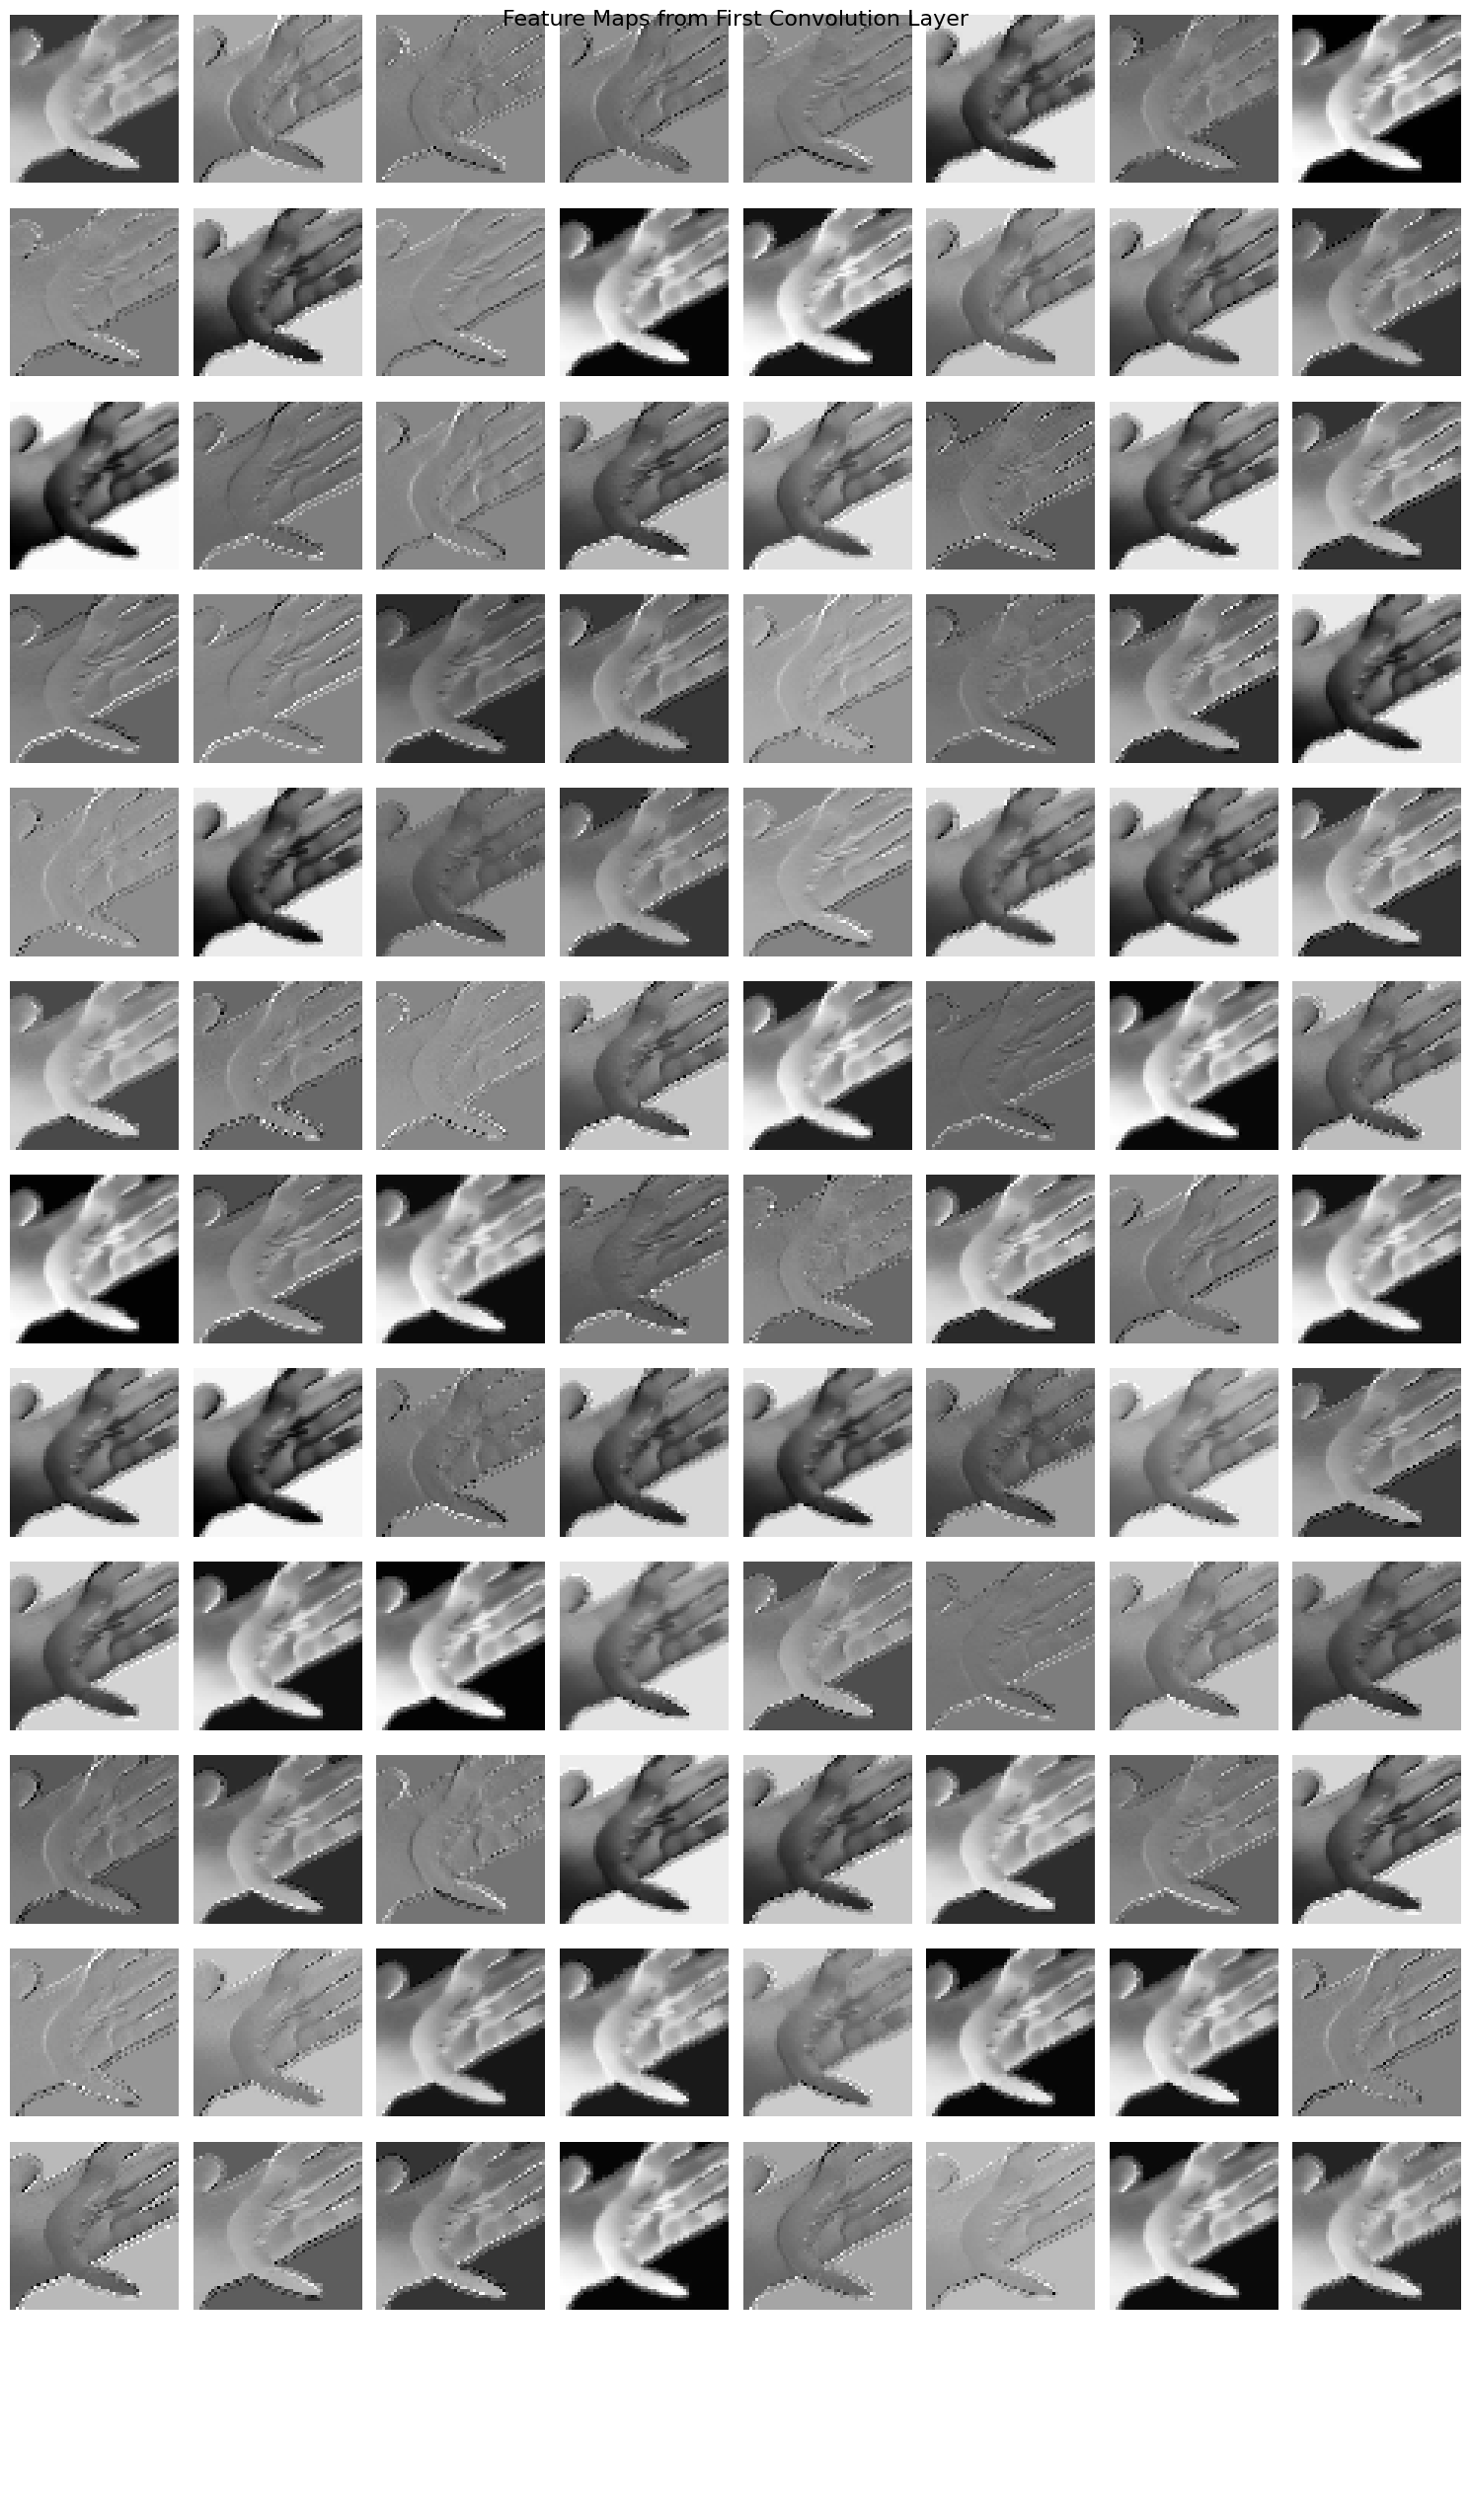

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Function to visualize feature maps from the first convolutional layer
def visualize_feature_maps(model, image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

    model.eval()
    with torch.no_grad():
        for name, layer in model.named_children():
            if name == "stem":  # First layer of ConvNeXt-Tiny
                feature_maps = layer[0](image)  # Forward pass through first conv layer
                break

    feature_maps = feature_maps.cpu().squeeze(0)  # Remove batch dimension

    # Normalize feature maps for better visibility
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    num_features = feature_maps.shape[0]
    cols = 8  # Number of columns for visualization
    rows = (num_features // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))  # Adjust spacing
    fig.suptitle("Feature Maps from First Convolution Layer", fontsize=16)

    for i in range(num_features):
        ax = axes[i // cols, i % cols]
        ax.imshow(feature_maps[i].numpy(), cmap="gray")
        ax.axis("off")

    # Hide unused subplots
    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis("off")

    plt.tight_layout()
    plt.show()

# Define the test image path
test_image_path = "/kaggle/working/split_data2/val/healthy/Healthy (112).jpg"
# Example: Visualize feature maps for a test image
visualize_feature_maps(model, test_image_path)

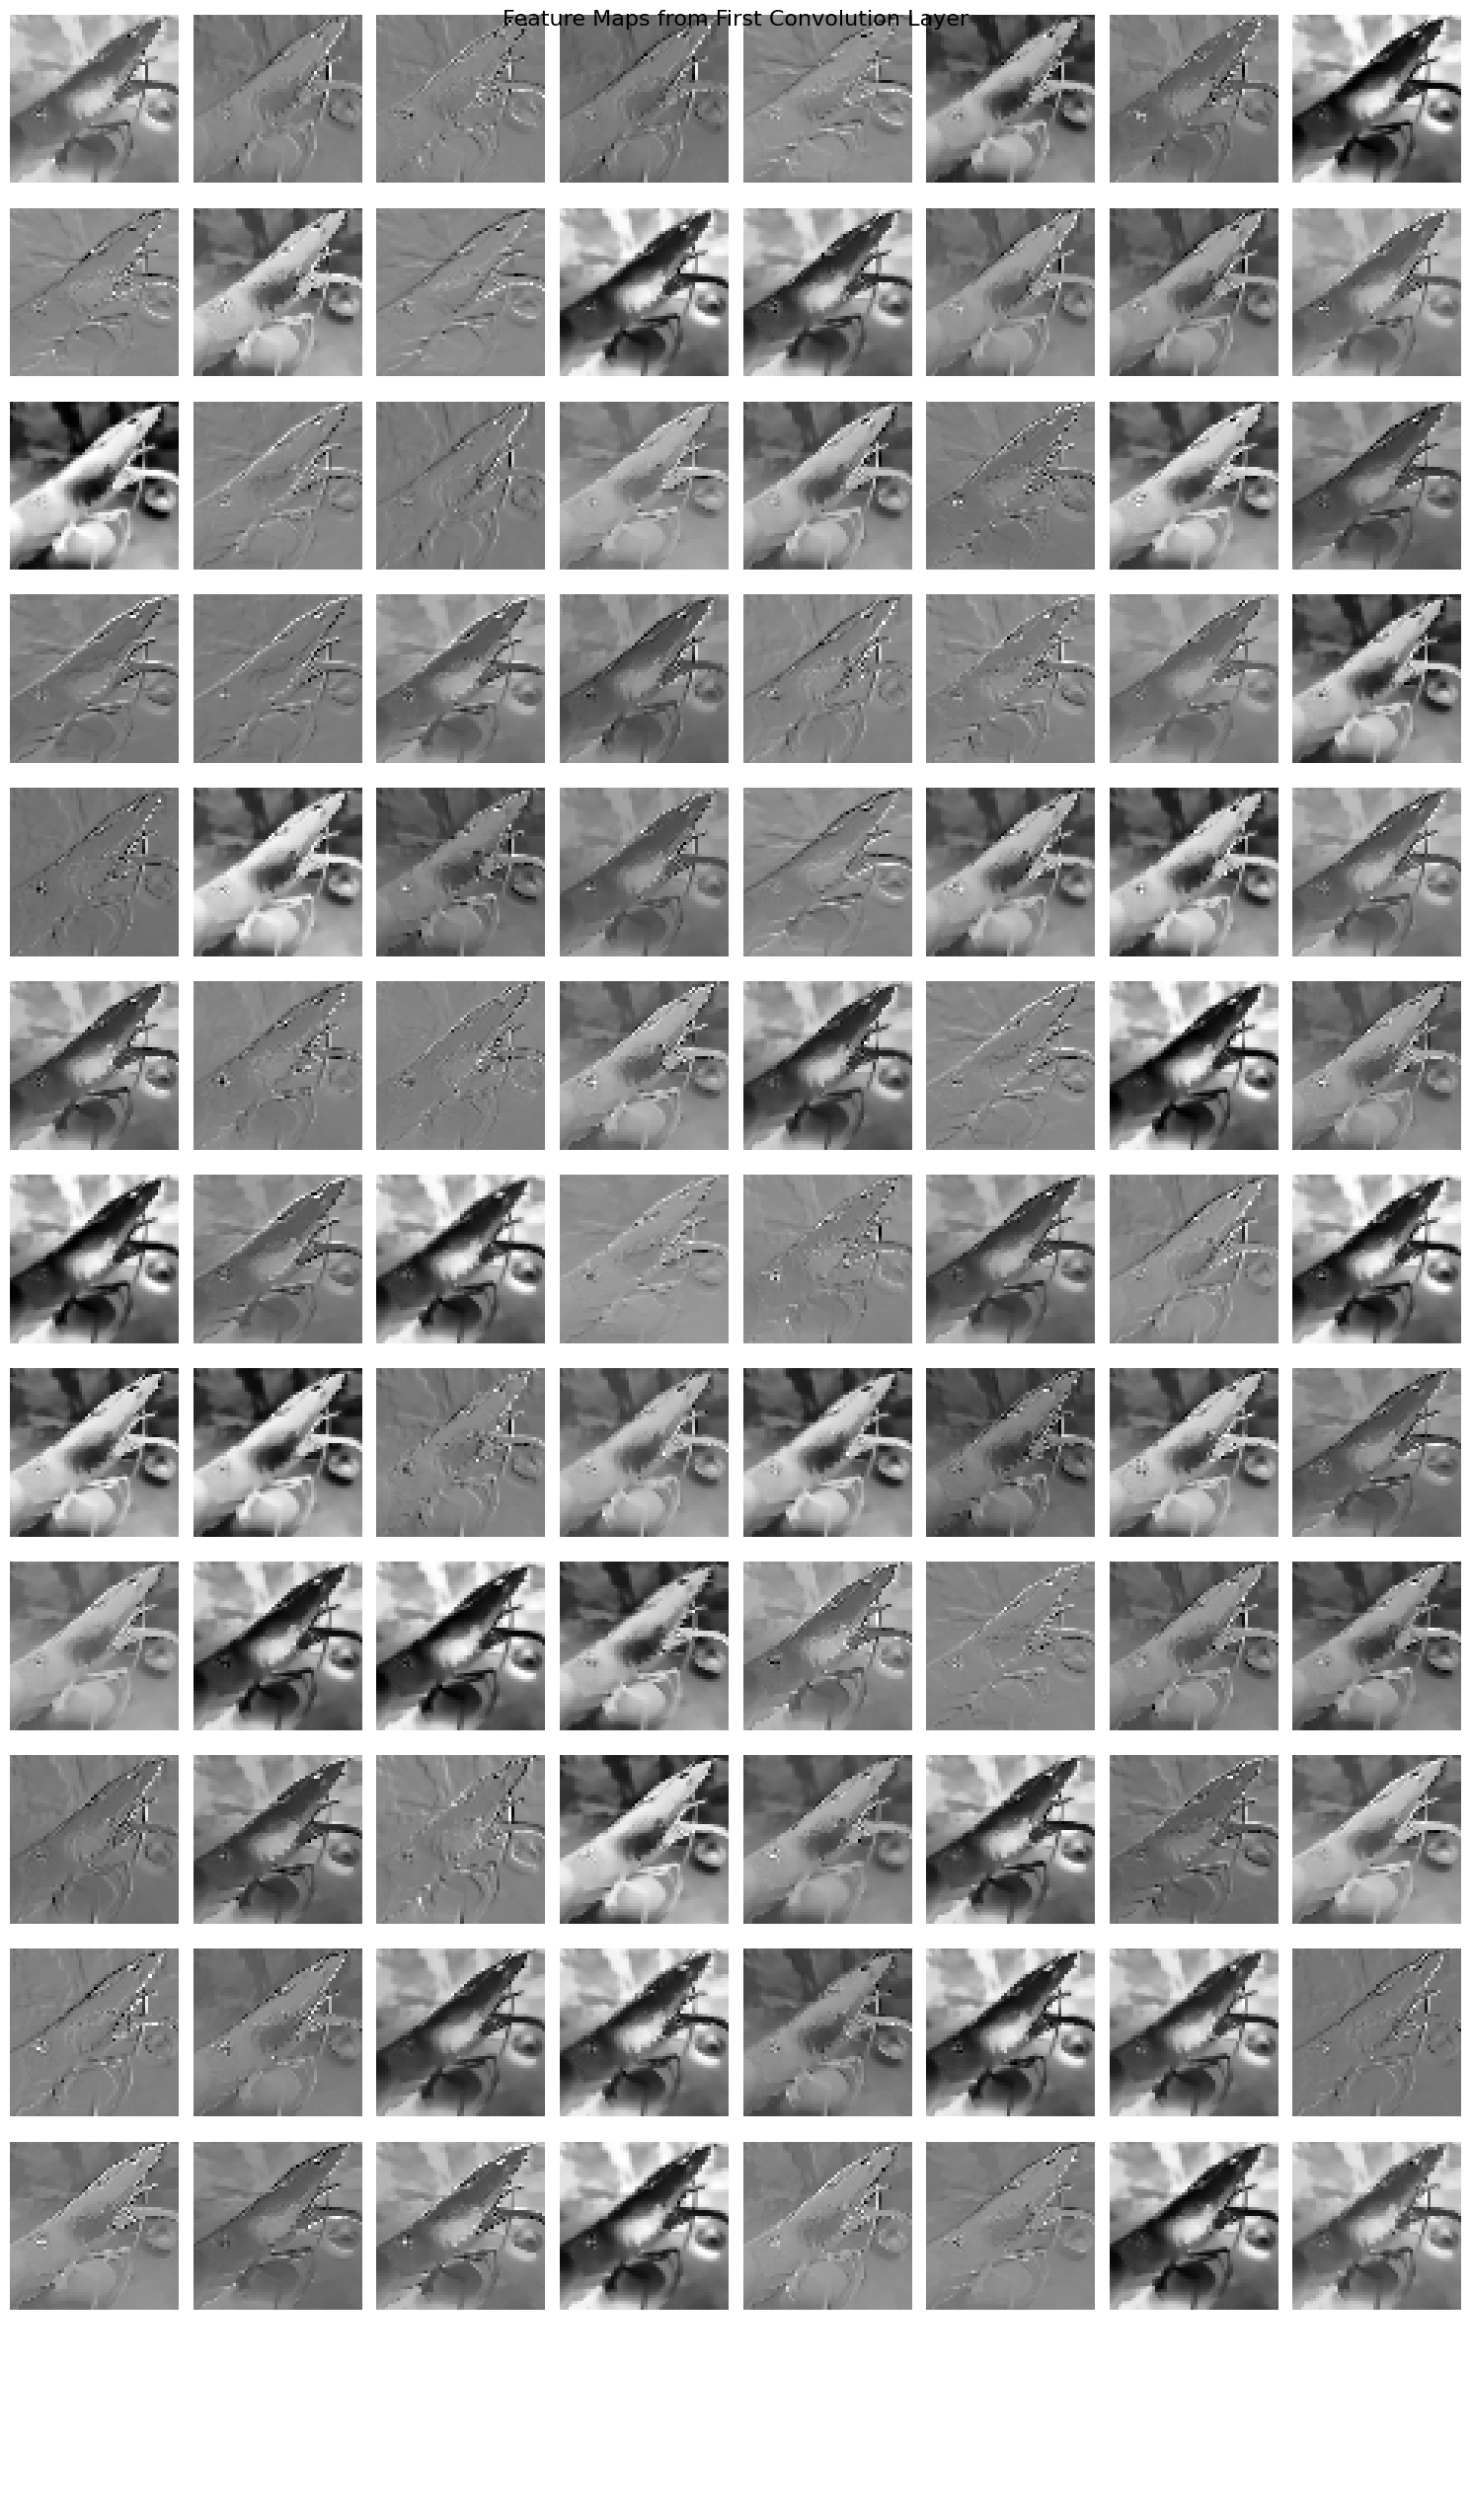

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Function to visualize feature maps from the first convolutional layer
def visualize_feature_maps(model, image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

    model.eval()
    with torch.no_grad():
        for name, layer in model.named_children():
            if name == "stem":  # First layer of ConvNeXt-Tiny
                feature_maps = layer[0](image)  # Forward pass through first conv layer
                break

    feature_maps = feature_maps.cpu().squeeze(0)  # Remove batch dimension

    # Normalize feature maps for better visibility
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    num_features = feature_maps.shape[0]
    cols = 8  # Number of columns for visualization
    rows = (num_features // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))  # Adjust spacing
    fig.suptitle("Feature Maps from First Convolution Layer", fontsize=16)

    for i in range(num_features):
        ax = axes[i // cols, i % cols]
        ax.imshow(feature_maps[i].numpy(), cmap="gray")
        ax.axis("off")

    # Hide unused subplots
    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis("off")

    plt.tight_layout()
    plt.show()

# Define the test image path
test_image_path = "/kaggle/working/split_data2/val/black_gills/Black_gills (105).jpg"
# Example: Visualize feature maps for a test image
visualize_feature_maps(model, test_image_path)

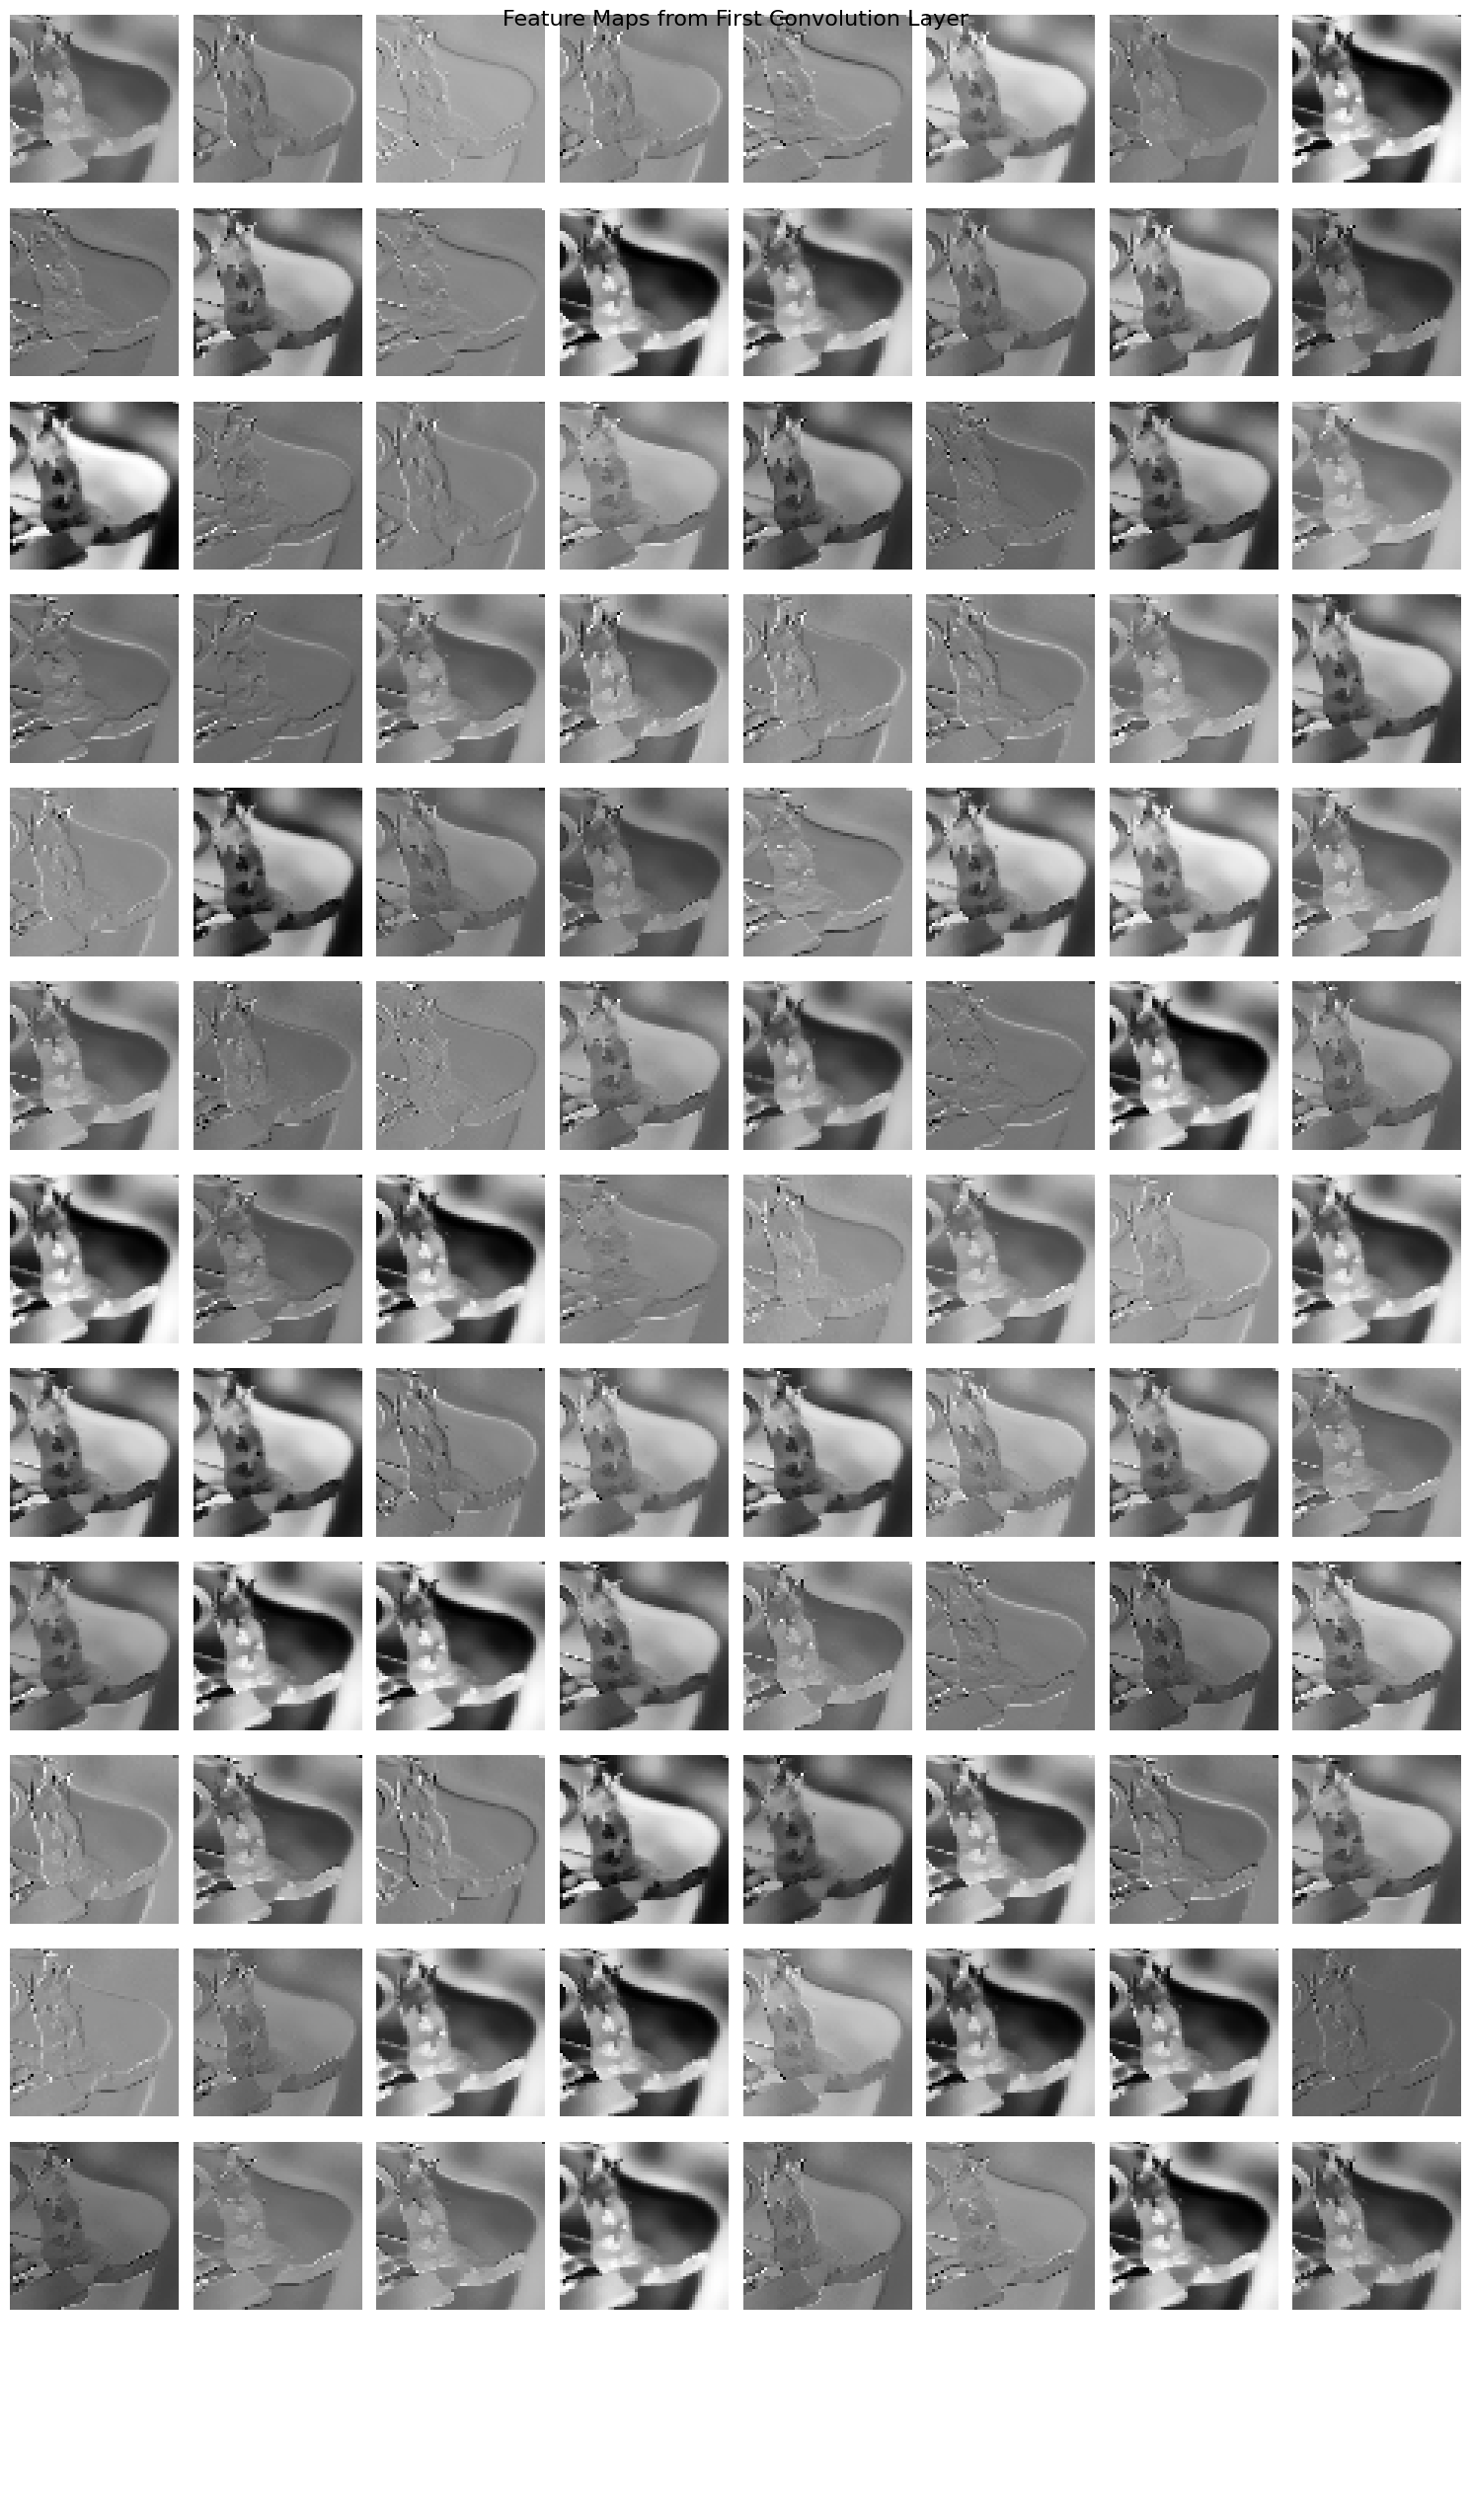

In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Function to visualize feature maps from the first convolutional layer
def visualize_feature_maps(model, image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

    model.eval()
    with torch.no_grad():
        for name, layer in model.named_children():
            if name == "stem":  # First layer of ConvNeXt-Tiny
                feature_maps = layer[0](image)  # Forward pass through first conv layer
                break

    feature_maps = feature_maps.cpu().squeeze(0)  # Remove batch dimension

    # Normalize feature maps for better visibility
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    num_features = feature_maps.shape[0]
    cols = 8  # Number of columns for visualization
    rows = (num_features // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))  # Adjust spacing
    fig.suptitle("Feature Maps from First Convolution Layer", fontsize=16)

    for i in range(num_features):
        ax = axes[i // cols, i % cols]
        ax.imshow(feature_maps[i].numpy(), cmap="gray")
        ax.axis("off")

    # Hide unused subplots
    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis("off")

    plt.tight_layout()
    plt.show()

# Define the test image path
test_image_path = "/kaggle/working/split_data2/val/black_spots/Black_spots (505).jpg"
# Example: Visualize feature maps for a test image
visualize_feature_maps(model, test_image_path)

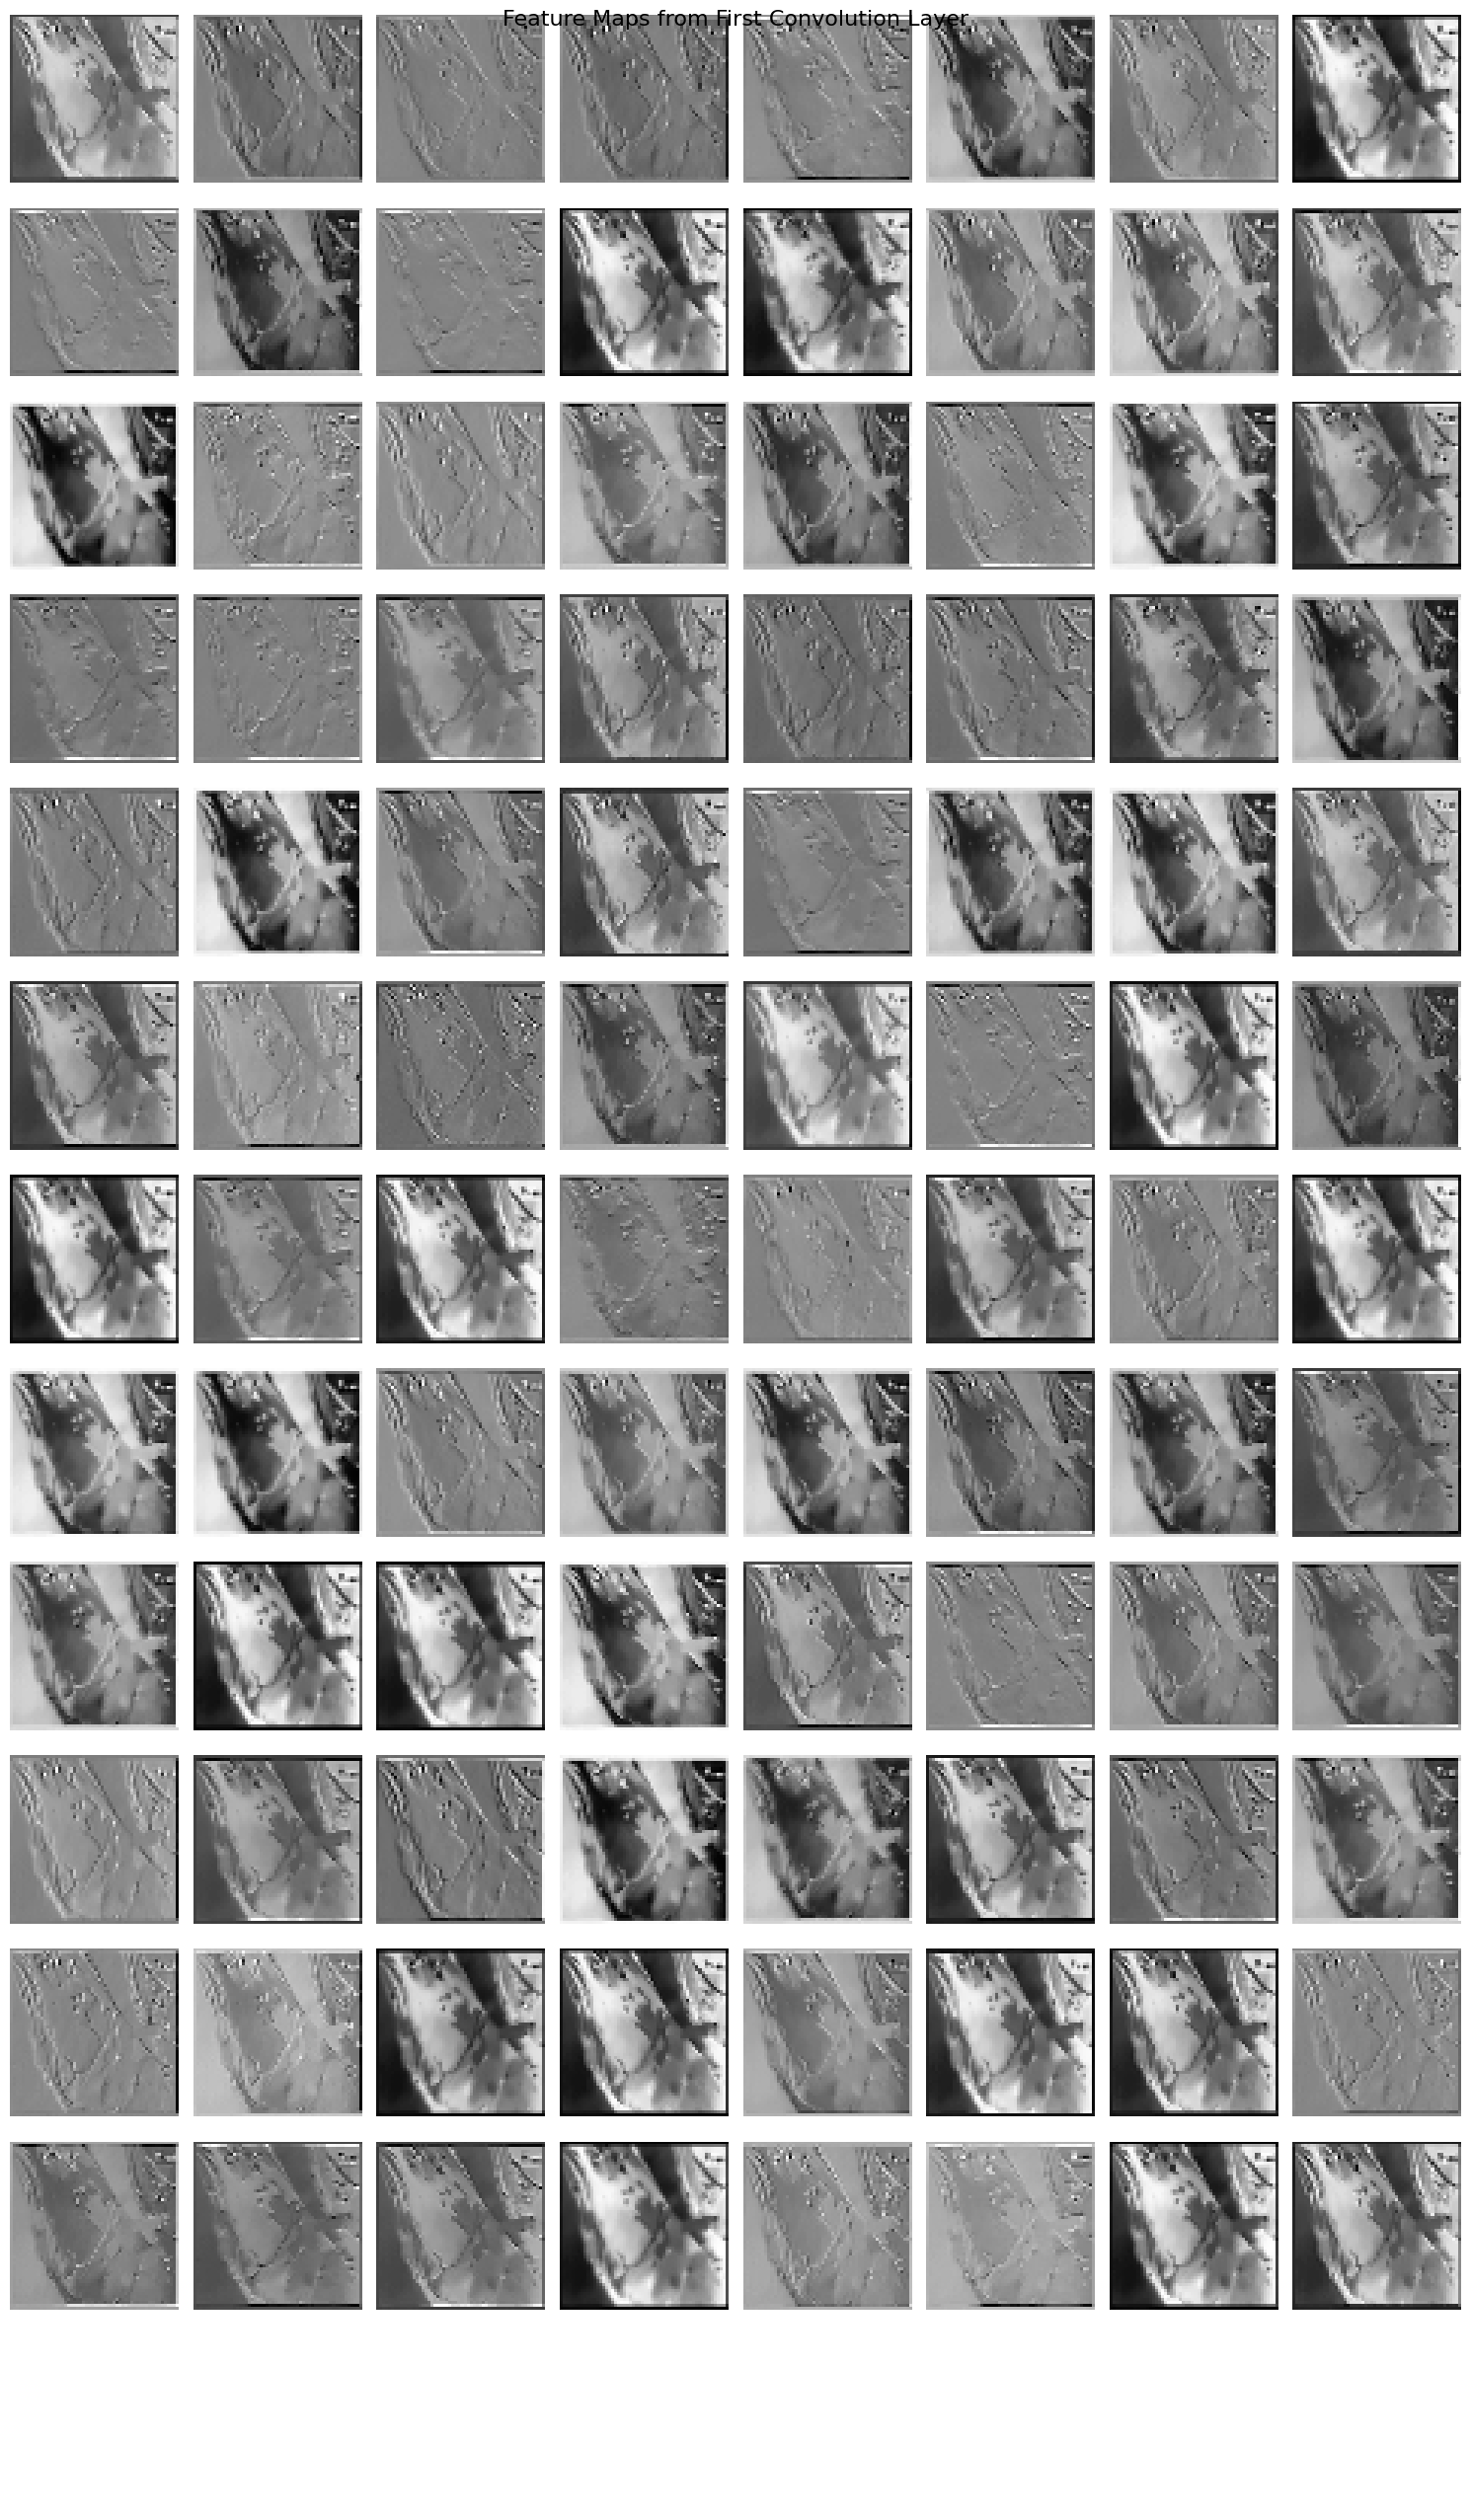

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Function to visualize feature maps from the first convolutional layer
def visualize_feature_maps(model, image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

    model.eval()
    with torch.no_grad():
        for name, layer in model.named_children():
            if name == "stem":  # First layer of ConvNeXt-Tiny
                feature_maps = layer[0](image)  # Forward pass through first conv layer
                break

    feature_maps = feature_maps.cpu().squeeze(0)  # Remove batch dimension

    # Normalize feature maps for better visibility
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    num_features = feature_maps.shape[0]
    cols = 8  # Number of columns for visualization
    rows = (num_features // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))  # Adjust spacing
    fig.suptitle("Feature Maps from First Convolution Layer", fontsize=16)

    for i in range(num_features):
        ax = axes[i // cols, i % cols]
        ax.imshow(feature_maps[i].numpy(), cmap="gray")
        ax.axis("off")

    # Hide unused subplots
    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis("off")

    plt.tight_layout()
    plt.show()

# Define the test image path
test_image_path = "/kaggle/working/split_data2/val/white_spots/White_spots  (113).jpg"
# Example: Visualize feature maps for a test image
visualize_feature_maps(model, test_image_path)